## Imports

In [3]:
# !pip install hyperopt

import warnings
warnings.filterwarnings("ignore")

from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import joblib
import pickle

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

In [4]:
with open('Saved data/X_train.pickle', 'rb') as data:
    X_train = pickle.load(data)
    
with open('Saved data/X_test.pickle', 'rb') as data:
    X_test = pickle.load(data)

with open('Saved data/X_train_scaled.pickle', 'rb') as data:
    X_train_scaled = pickle.load(data)
    
with open('Saved data/X_test_scaled.pickle', 'rb') as data:
    X_test_scaled = pickle.load(data)
    
with open('Saved data/X_train_pca.pickle', 'rb') as data:
    X_train_pca = pickle.load(data)
    
with open('Saved data/X_test_pca.pickle', 'rb') as data:
    X_test_pca = pickle.load(data)
    
with open('Saved data/X_train_autoencoder.pickle', 'rb') as data:
    X_train_autoencoder = pickle.load(data)
    
with open('Saved data/X_test_autoencoder.pickle', 'rb') as data:
    X_test_autoencoder = pickle.load(data)
    
with open('Saved data/y_train.pickle', 'rb') as data:
    y_train = pickle.load(data)
    
with open('Saved data/y_test.pickle', 'rb') as data:
    y_test = pickle.load(data)
    
with open('Saved data/labels.pickle', 'rb') as data:
    labels = pickle.load(data)

In [5]:
num_pipe = Pipeline([('scaler', StandardScaler())])
transformer = num_pipe

In [6]:
model = Pipeline([('transformer', transformer),
                  ('lr', LogisticRegression(random_state=1, n_jobs=-1, max_iter=2000, solver='saga'))])

In [7]:
search_space = {
                'lr__penalty' : hp.choice(label='penalty', 
                          options=['l2', 'l1']),
                'lr__C' : hp.loguniform(label='C', 
                        low=-4*np.log(10), 
                        high=2*np.log(10))
                }

In [8]:
def objective(params, pipeline,  X_train, y_train):
    """
    Кросс-валидация с текущими гиперпараметрами

    :params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор меток объектов
    :return: средняя точность на кросс-валидации
    """ 

    # задаём модели требуемые параметры    
    pipeline.set_params(**params)

    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

    # проводим кросс-валидацию  
    score = cross_val_score(estimator=pipeline, X=X_train, y=y_train, cv=skf, n_jobs=-1, scoring='recall_macro')

    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}

In [9]:
# запускаем hyperopt
trials = Trials()
best = fmin( 
          # функция для оптимизации  
            fn=partial(objective, pipeline=model, X_train=X_train, y_train=y_train),
          # пространство поиска гиперпараметров  
            space=search_space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать и время поиска) 
            max_evals=5,
          # куда сохранять историю поиска
            trials=trials,
          # random state
            rstate=np.random.default_rng(1),
          # progressbar
            show_progressbar=True
        )


100%|█████████████████████████████████████████████| 5/5 [1:32:28<00:00, 1109.74s/trial, best loss: -0.8446217940341736]


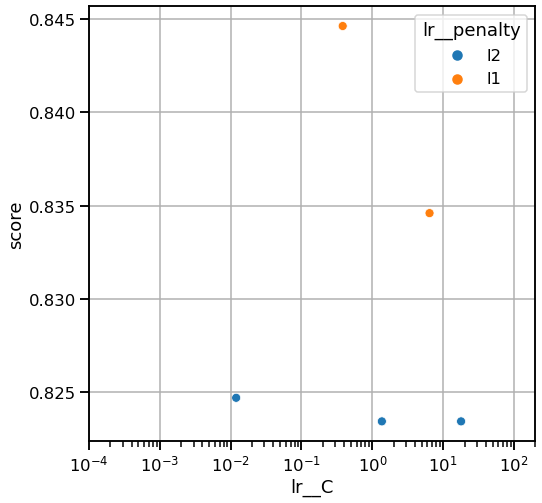

In [13]:
def df_results(hp_results):
    """
    Отображаем результаты hyperopt в формате DataFrame 

    :hp_results: результаты hyperop
    :return: pandas DataFrame
    """ 

    results = pd.DataFrame([{**x, **x['params']} for x in  hp_results])
    results.drop(labels=['status'],axis=1, inplace=True)
    results['loss'] = results['loss'].apply(lambda x: -x)
    results.sort_values(by=['loss'], ascending=True, inplace=True)
    results['score'] = results['loss']
    results.drop('loss', axis=1, inplace=True)
    return results

results = df_results(trials.results)
sns.set_context("talk")
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x='lr__C', y='score', hue='lr__penalty', data=results);
ax.set_xscale('log')
ax.set_xlim(1e-4, 2e2)
ax.grid()


In [15]:
results[::-1]['score'].iloc[0] # best recall score while training

0.8446217940341736

In [18]:
results[::-1]['params'].iloc[0]  # best params

{'lr__C': 0.38185592693331355, 'lr__penalty': 'l1'}

In [7]:
lr = LogisticRegression(C=0.38185592693331355, penalty='l1', solver='saga')
lr.fit(X_train_scaled, y_train)
pred = lr.predict(X_test_scaled)
print(classification_report(pred, y_test, target_names=labels))

              precision    recall  f1-score   support

       Basal       0.95      1.00      0.97        19
        Her2       0.82      0.86      0.84        21
        LumA       0.96      0.94      0.95        69
        LumB       0.89      0.87      0.88        47

    accuracy                           0.92       156
   macro avg       0.90      0.92      0.91       156
weighted avg       0.92      0.92      0.92       156



In [5]:
joblib.dump(lr, 'Saved models & utils/LR_Hyperopt.pkl')

['LR_Hyperopt.pkl']